In [41]:
import os
import numpy as np
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld, ToTensord,
    ScaleIntensityd,SpatialPadd,
    LambdaD, NormalizeIntensityd, ScaleIntensityd, RandSpatialCropSamplesd,
    RandFlipd, RandRotate90d, RandShiftIntensityd, RandCoarseDropoutd, CopyItemsd,
    OneOf, RandCoarseShuffled
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.networks.nets import UNETR
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.metrics import DiceMetric

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [102]:
# printing the results
device = torch.device("cpu")

# Define the transformation pipeline for the single image
def threshold_image(image):
    return np.where(image < 0.08, 0, image)

single_image_transforms = Compose(
    [
        LoadImaged(keys=["image"], reader="nrrdreader"),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityd(keys=["image"], minv=0, maxv=1),
        LambdaD(keys="image", func=threshold_image),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys="image", spatial_size=(64, 64, 64)),
        ToTensord(keys=["image"]),
    ]
)

train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityd(keys=["image"], minv=0, maxv=1),
    LambdaD(keys="image", func=threshold_image),
    CropForegroundd(keys=["image"], source_key="image"),
    SpatialPadd(keys=["image"], spatial_size=(64, 64, 64)),
#    RandSpatialCropSamplesd(keys=["image"], roi_size=(
#        64, 64, 64), random_size=False, num_samples=2),
    RandFlipd(keys=["image"], spatial_axis=[0], prob=0.10),
    RandFlipd(keys=["image"], spatial_axis=[1], prob=0.10),
    RandFlipd(keys=["image"], spatial_axis=[2], prob=0.10),
    RandRotate90d(keys=["image"], prob=0.10, max_k=3),
    RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ToTensord(keys=["image"]),
])

image_size = 128
ssl_train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ScaleIntensityd(keys=["image"], minv=0, maxv=1),
        #LambdaD(keys="image", func=threshold_image),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(image_size, image_size, 32)),
        RandSpatialCropSamplesd(keys=["image"], roi_size=(
            image_size, image_size, 32), random_size=False, num_samples=2),
        CopyItemsd(keys=["image"], times=2, names=[
            "gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=64
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=image_size
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=64
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=image_size
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8,
                           holes=10, spatial_size=8),
    ]
)

# Example NRRD file path
#image_file = "../Data/VoiceUsers/Val/Nasal25/6 3DGRE_A FATHER 3D.nrrd"
image_file = "../Data/FrenchSpeakerDataset/NRRD_Files_N4Bias_Denoised/P1_ra.nrrd"

# Create a dictionary for the single image
single_image_data = [{"image": image_file}]

# Create a Dataset for the single image
single_image_ds = CacheDataset(data=single_image_data, transform=ssl_train_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)

# Load and preprocess the image
single_image_loader = DataLoader(single_image_ds, batch_size=1)
single_image_batch = next(iter(single_image_loader))
single_image = single_image_batch["image"]

# Print the shape of the preprocessed image
print(f"Preprocessed image shape: {single_image.shape}")


Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

Preprocessed image shape: torch.Size([2, 1, 128, 128, 32])


(36, 320, 290)


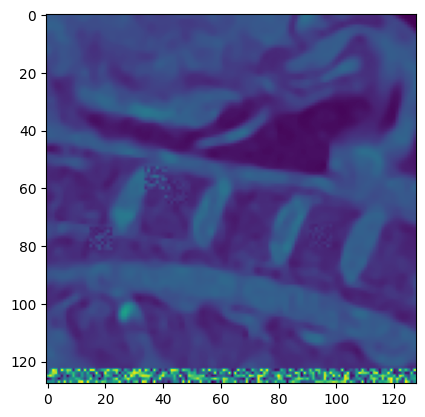

In [103]:
# Show image from the dataloader
import matplotlib.pyplot as plt
import SimpleITK as sitk

plt.imshow(single_image[0,0,:,:,20])
actual_image = sitk.ReadImage(image_file)
image_arr = sitk.GetArrayFromImage(actual_image)
print(image_arr.shape)




In [5]:
import tqdm
import mlflow.pytorch
# Define the model (for example, UNet)
model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(64, 64, 64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="conv",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.5,
)

# Load pre-trained model weights (modify the path as needed)
# model.load_state_dict(torch.load(
#     "./logs/FineTune/FrenchSpeaker-Thresh-255-10000St.pth"))

########################################## Loading the MLFlow models
model_path = "./mlruns/168396703495509528/f57e8724880841ae91640aef95db0c0f/artifacts/models/Prototyping_final/data/model.pth"

# Load the model using the correct path
model = torch.load(model_path)
model.to(device)
model.eval()
####################################


# Perform inference

with torch.no_grad():
        single_image = single_image.to(device)
        output = sliding_window_inference(single_image,(64, 64, 64), 4, model)

# Convert the output to a binary mask
# output = torch.argmax(output, dim=1).cpu().numpy()
#print(f"Segmentation output shape: {output.shape}")


/home/erattakulangara/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


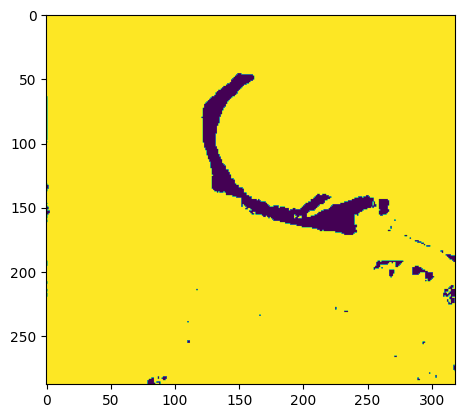

In [7]:
import matplotlib.pyplot as plt
plt.imshow(output[0,0,:,:,35]>0.2)

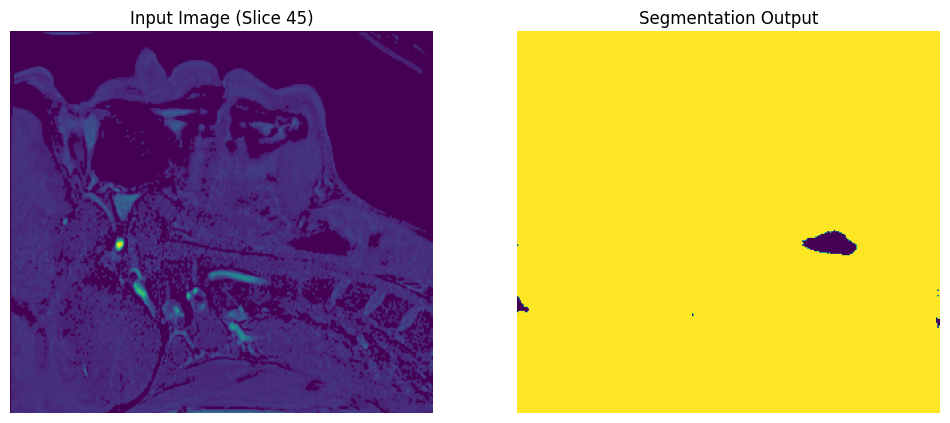

In [10]:
import matplotlib.pyplot as plt
# Extract a slice from the input image and the segmentation output
slice = 45

input_slice = single_image[0, 0, :, :, slice].cpu().numpy()  # Extracting slice 16
output_slice = output[0,0, :, :, slice]>0.2  # Extracting the same slice from the output

# Visualize input and output as subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Input image subplot
axes[0].imshow(input_slice)
axes[0].set_title(f"Input Image (Slice {slice})")
axes[0].axis("off")

# Segmentation output subplot
axes[1].imshow(output_slice)
axes[1].set_title("Segmentation Output")
axes[1].axis("off")

plt.show()
